# Chromatic albedo variations as a possible source of the CHEOPS and TESS discrepancy

**Author:** Hannu Parviainen<br>
**Last edited:** 10.8.2022

The albedo spectrum of a planet (or, as in our case, a brown dwarf) can feature clear distinct regions of low and high reflectivity in wavelength space (Sudarsky2000, Burrows2008). In theory, a low blue-optical albedo combined with a high NIR albedo could be explained with silicate clouds and a strong optical absorber above the silicate cloud deck (such as gaseous TiO/VO or S$_2$/HS, Schwartz2015), and there is a possibility that the discrepancy between the *CHEOPS* and *TESS* dayside flux ratios could be explained by a high-contrast feature in KELT-1b's albedo spectrum. 

Here we'll take a look whether the discrepancy between the CHEOPS and TESS band dayside flux ratios can be explained by chromatic variations in the albedo. We use a simplest possible albedo spectrum model (a step function between two different geometric albedo levels) and a BT-Settl stellar spectrum model by Allard (2013).

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sb
import xarray as xa
import arviz as az

from pathlib import Path
from numpy import max
from scipy.interpolate import RegularGridInterpolator
from seaborn.utils import set_hls_values

from pytransit.stars import create_bt_settl_interpolator

from src import FinalLPF
from src.kelt1 import read_mcmc, derive_qois, AAPGW, AAOCW, filter_names, star_teff, filters

rc('figure', figsize=(13,5))
c_light_blue = set_hls_values("C0", l=0.8, s=0.5)

def fratio_reflection(ag, a):
    return ag / a**2

def ag_from_fratio(fr, a):
    return a**2 * fr

df = read_mcmc('results/03b_fin_emission_and_constrained_ev.nc')
sma = derive_qois(df).a.median()
_, fr_day = FinalLPF('b').calculate_flux_ratios(permutation(df)[:10_000])
flux_ratios = pd.DataFrame(fr_day.T, columns=[c.replace('log10_ted_', '') for c in df.columns if 'ted' in c])

## Create a utility wrapper for the BT-Settl spectra

I (HP) need to improve the BT-Settl and Husser2013 spectrum interpolation inside PyTransit. This utility wrapper will hopefully not be needed in the future, but now we need to do this the hard way.

In [5]:
class BTSpectrum():
    def __init__(self):
        self._ip = create_bt_settl_interpolator()
        
    def spectrum(self, t, wl=None):
        if wl is None:
            wl = self._ip.grid[1]
        return wl, self._ip(transpose([full_like(wl, t), wl]))

    def flux_ratio(self, tcomp, tstar, lmin=300, lmax=5000):
        wl = self._ip.grid[1]
        wl = wl[(wl >= lmin) & (wl <= lmax)]
        return wl, self.spectrum(tcomp, wl)[1] / self.spectrum(tstar, wl)[1]

    def integrated_flux_ratio(self, tcomp, tstar, filters, lmin=300, lmax=5000):
        wl, fr = self.flux_ratio(tcomp, tstar, lmin, lmax)
        return [average(fr, weights=f(wl)) for f in filters]

## Define the albedo spectrum model

We model the albedo spectrum with a simple step function between two constant geometric albedo levels.

In [6]:
def step_albedo(wl, wl0, ag1, ag2):
    return where(wl < wl0, ag1, ag2)

Let's also plot an example albedo spectrum model with the stellar spectrum model.

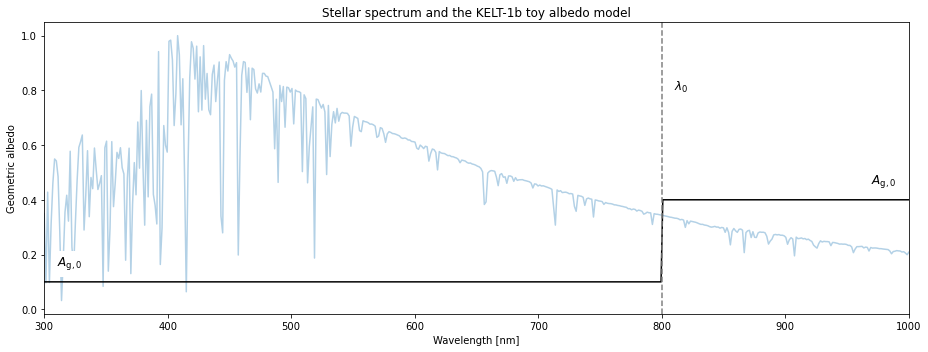

In [7]:
bts = BTSpectrum()

wl0, ag1, ag2 = 800, 0.1, 0.4
x = linspace(300, 1000, 500)
fig, ax = subplots()
wl, fl = bts.spectrum(star_teff.n, x)
ax.plot(wl, fl / fl.max(), c=set_hls_values("C0", l=0.8, s=0.5))
ax.plot(x, step_albedo(x, wl0, ag1, ag2), 'k')
ax.axvline(wl0, c='0.5', ls='--')
ax.text(310, ag1+0.06, '$A_\mathrm{g,0}$', size='large', backgroundcolor='w')
ax.text(1000-10, ag2+0.06, '$A_\mathrm{g,0}$', size='large', ha='right')
ax.text(wl0+10, 0.8, '$\lambda_0$', size='large')
setp(ax, xlim=x[[0, -1]], xlabel='Wavelength [nm]', ylabel='Geometric albedo', 
     title='Stellar spectrum and the KELT-1b toy albedo model')
fig.tight_layout()

## Take a look at the ratios of TESS and CHEOPS dayside fluxes

First, we'll need to understand how large the discrepancy between the CHEOPS and TESS passband dayside flux ratios is. The most straightforward way to do this is to take a look at the ratios of TESS and CHEOPS dayside flux ratios (*I'll call the CHEOPS and TESS dayside flux ratios fluxes from now on to keep the text clean*).

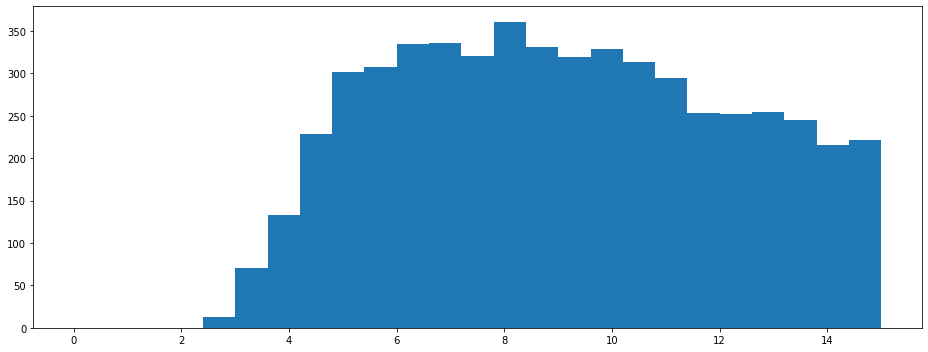

In [8]:
fig, ax  = subplots()
fr = (flux_ratios.TESS / flux_ratios.CHEOPS).values
ax.hist(fr, range=(0,15), bins=25)
fig.tight_layout()

However, the CHEOPS and TESS dayside fluxes still contain contribution from thermal emission.

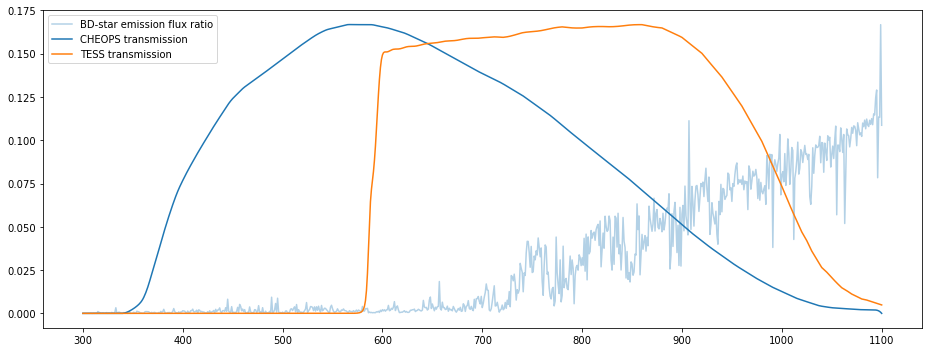

In [9]:
bts = BTSpectrum()
fig, ax  = subplots()
wl, fr = bts.flux_ratio(3000, star_teff.n, lmax=1100)
ax.plot(wl, fr, c=c_light_blue, label='BD-star emission flux ratio')
ax.plot(wl, filters[0](wl) * fr.max(), label='CHEOPS transmission')
ax.plot(wl, filters[1](wl) * fr.max(), label='TESS transmission')
ax.legend()
fig.tight_layout()

We derive a set of "reflection only" flux ratios using a Monte Carlo aproach assuming that KELT-1b's temperature is somewhere between 2800 and 3200 K. That is, we draw `ns` KELT-1b temperature samples, calculate and subtract the emission flux ratios from a random set of our posterior flux ratio samples. This leads to a pretty rough estimate of the actual effect (and we can't really rule out biases), but allows us to get an idea of the actual reflection-dependent contrast between the CHEOPS and TESS flux ratios.  

**Note:** this is rather inefficient way of doing the sampling and will take some time...

In [10]:
bts = BTSpectrum()
ns_final = 2000
ns_try = 250
finished = False

ns_total = 0
reflection_fratios = []
while not finished:        
    brightness_temperatures = uniform(2800, 3200, size=ns_try)
    emission_fratios = array([bts.integrated_flux_ratio(tb, star_teff.n, filters) for tb in brightness_temperatures])
    reflection_fratios_try = flux_ratios.iloc[permutation(flux_ratios.shape[0])[:ns_try], :] - emission_fratios
    m = reflection_fratios_try.CHEOPS > 0.001
    reflection_fratios.append(reflection_fratios_try[m])
    ns_total += m.sum()
    if ns_total >= ns_final:
        finished = True
reflection_fratios = pd.concat(reflection_fratios)

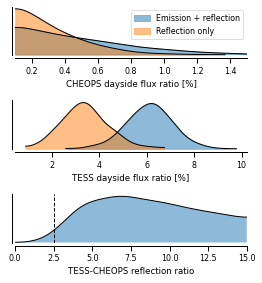

In [13]:
with sb.plotting_context('paper', font_scale=0.9):
    fig, axs = subplots(3, 1, figsize=(AAOCW, 1.1*AAOCW))
    az.plot_kde(1e2*flux_ratios.CHEOPS.values, bw=0.1, ax=axs[0], plot_kwargs={'lw':1, 'c':'k'},
                fill_kwargs={'alpha':0.5, 'color':'C00'}, label='Emission + reflection')
    az.plot_kde(1e2*reflection_fratios.CHEOPS.values, bw=0.1, ax=axs[0], plot_kwargs={'lw':1, 'c':'k'},
                fill_kwargs={'alpha':0.5, 'color':'C01'}, label='Reflection only')
    az.plot_kde(1e2*flux_ratios.TESS.values, bw=0.3, ax=axs[1], 
                plot_kwargs={'lw':1, 'c':'k'},
                fill_kwargs={'alpha':0.5, 'color':'C00'})
    az.plot_kde(1e2*reflection_fratios.TESS.values, bw=0.3, ax=axs[1],
                plot_kwargs={'lw':1, 'c':'k'},
                fill_kwargs={'alpha':0.5, 'color':'C01'})
    r = reflection_fratios.TESS.values / reflection_fratios.CHEOPS.values
    rx, ry = az.kde(r[r<15], custom_lims=(0,15), bw=1)
    axs[2].fill_between(rx, ry, alpha=0.5)
    axs[2].plot(rx, ry, lw=1, c='k')
    axs[2].axvline(2.5, lw=1, c='k', ls='--')
    axs[0].legend()
    [ax.autoscale(axis='y', tight=True) for ax in axs]
    setp(axs[0], xlim=(0.1, 1.5), xlabel='CHEOPS dayside flux ratio [%]')
    setp(axs[1], xlabel='TESS dayside flux ratio [%]')
    setp(axs[2], xlim=(0, 15), xlabel='TESS-CHEOPS reflection ratio', xticks=linspace(0, 15, 7))
    setp(axs, yticks=[])
    for ax in axs:
        yl = ax.get_ylim()
        ax.set_ylim((yl[0], 1.05*yl[1]))
    sb.despine(fig, offset=3)
    fig.tight_layout()
    fig.subplots_adjust(left=0.03, right=0.96, bottom=0.13, top=0.99)
    fig.savefig('plots/cheops_vs_tess_albedo_3.pdf')

## Calculate the reflected flux ratios
### Main test

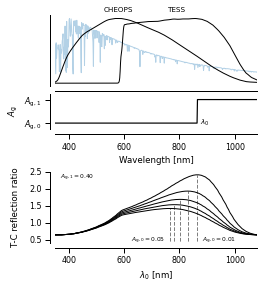

In [14]:
ag1s = array([0.01, 0.02, 0.03, 0.04, 0.05])
ag2 = 0.4
l0s = linspace(350, 1080, 150)
wl, flux_star = bts.spectrum(star_teff.n, wl=linspace(350, 1080, 500))
frs = zeros([ag1s.size, l0s.size])

for j, ag1 in enumerate(ag1s):
    for i, l0 in enumerate(l0s):
        fc = (flux_star * filters[0](wl) * step_albedo(wl, l0, ag1, ag2)).sum()
        ft = (flux_star * filters[1](wl) * step_albedo(wl, l0, ag1, ag2)).sum()
        frs[j, i] = ft/fc
    
with sb.plotting_context('paper', font_scale=0.9):
    gs1 = GridSpec(3, 1, height_ratios=[0.4, 0.2, 0.6], hspace=0.1)
    gs2 = GridSpec(3, 1, height_ratios=[0.4, 0.2, 0.6], hspace=0.9)

    fig = figure(figsize=(AAOCW, 1.1*AAOCW))
    a1 = fig.add_subplot(gs1[0])
    a2 = fig.add_subplot(gs1[1])
    a3 = fig.add_subplot(gs2[2])

    l0m = l0s[argmax(frs)]
    a1.plot(wl, flux_star / flux_star.max(), lw=1, c=c_light_blue)
    a1.plot(wl, filters[0](wl), lw=1, c='k')
    a1.plot(wl, filters[1](wl), lw=1, c='k')
    a1.text(580, 1.1, 'CHEOPS', size='small', ha='center')
    a1.text(790, 1.1, 'TESS', size='small', ha='center')
    
    a2.plot(wl, step_albedo(wl, l0m, 0.01, ag2), 'k', ls='-')
    a2.text(l0m+10, 0.01, '$\lambda_0$', size='small', ha='left', va='center')
    
    for j in range(ag1s.size):
        a3.plot(l0s, frs[j], 'k', lw=1)
        mfr = frs[j].max()
        ml0 = l0s[argmax(frs[j])]
        a3.plot((ml0, ml0), (0.0, mfr), lw=1, c='0.5', ls='--', zorder=-10)
    a3.text(0.025, 0.90, '$A_\mathrm{g,1} = 0.40$', transform=a3.transAxes, size='x-small')
    a3.text(880, 0.43, '$A_\mathrm{g,0} = 0.01$', size='x-small')
    a3.text(750, 0.43, '$A_\mathrm{g,0} = 0.05$', size='x-small', ha='right')

    setp((a1,a2,a3), xlim=(350, 1080))
    setp(a1, yticks=[], xticks=[])
    setp(a2, ylim=(-0.09, 0.5), yticks=(0.01, 0.4), yticklabels=('$A_\mathrm{g,0}$', '$A_\mathrm{g,1}$'), 
         xlabel='Wavelength [nm]', ylabel='$A_\mathrm{g}$')
    setp(a3, xlabel='$\lambda_0$ [nm]', ylabel='T-C reflection ratio', yticks=[0.5, 1.0, 1.5, 2.0, 2.5], ylim=(0.4, 2.5))
    sb.despine(fig, offset=5)
    fig.align_ylabels()
    fig.subplots_adjust(bottom=0.12, top=.95, left=0.18, right=0.99)
    fig.savefig('plots/cheops_vs_tess_albedo_1d.pdf')

### Detailed 2D mapping

In [15]:
ag1s = linspace(0.01, 0.05, 50)
ag2 = 0.4
l0s = linspace(500, 1080, 50)
wl, flux_star = bts.spectrum(star_teff.n, wl=linspace(350, 1080, 200))
frs = zeros([l0s.size, ag1s.size])
for j, ag1 in enumerate(ag1s):
    for i, l0 in enumerate(l0s):
        fc = (flux_star * filters[0](wl) * step_albedo(wl, l0, ag1, ag2)).sum()
        ft = (flux_star * filters[1](wl) * step_albedo(wl, l0, ag1, ag2)).sum()
        frs[i, j] = ft/fc

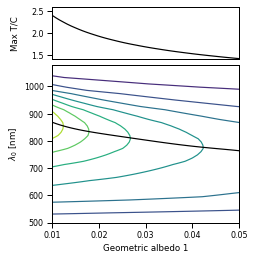

In [17]:
aip = RegularGridInterpolator((l0s, ag1s), frs)
pp = poly1d(polyfit(ag1s, l0s[argmax(frs, axis=0)], 5))

with sb.plotting_context('paper', font_scale=0.9):
    fig, axs = subplots(2, 1, figsize=(AAOCW, AAOCW), gridspec_kw={'height_ratios':[0.25, 0.75], 'hspace':0.05}, sharex='all')
    axs[0].plot(ag1s, aip((pp(ag1s), ag1s)), 'k')
    axs[1].contour(frs, extent=(ag1s[0], ag1s[-1], l0s[0], l0s[-1]))
    axs[1].plot(ag1s, pp(ag1s), 'k')
    setp(axs[0], ylabel='Max T/C', yticks=[1.5, 2.0, 2.5], ylim=(1.4, 2.6))
    setp(axs[1], xlabel='Geometric albedo 1', ylabel='$\lambda_0$ [nm]')
    setp(axs[0].get_xticklines(), visible=False)
    fig.align_ylabels()
    fig.tight_layout()
    fig.subplots_adjust(left=0.19, right=0.94, top=0.99)
    fig.savefig('plots/cheops_vs_tess_albedo_2d.pdf')

---

<center>&copy;2022 Hannu Parviainen</center>